# Code-Along - Machine Learning on AWS - Hands On Lab

## Table of Contents

<a href='#1'>1. AWS Set up (cont...)</a>

<br/>
<a href='#2'>2. Data Preparation</a>
<ul>
<a href='#2.1'><li>2.1 Download the MNIST Dataset</li></a>
<a href='#2.2'><li>2.2 Explore the Training Dataset</li></a>
</ul>
<br/>
<a href='#3'>3. Train a Model</a>
<ul>
<a href='#3.1'><li>3.1 Create a Training Job</li></a>
<a href='#3.2'><li>3.2 Start the Training Job</li></a>
<a href='#3.3'><li>3.3 Additional Notes - Implicit Actions</li></a>
</ul>

[4. Deploy the Model to Amazon SageMaker](#4)
<br/>
[5. Validate the Model](#5)
<br/>
[6. Clean Up](#6)
<br/>


<a id='1'></a>

### 1. AWS Set Up (cont...)

In [1]:
# The get_execution_role function retrieves the IAM role we created at the time of creating the notebook instance
from sagemaker import get_execution_role
role = get_execution_role()

# Add the name of the S3 bucket that you created in previous step
bucket = 'paragpansarez-sagemaker-1'

<a id='2'></a>

### 2. Data Preparation

<a id='2.1'></a>

#### 2.1 Download the MNIST Dataset 

In [2]:
%%time 
import pickle, gzip, numpy, urllib.request, json

# Download the MNIST dataset (mnist.pkl.gz) from the deeplearning.net website to your Amazon SageMaker notebook instance
# MNIST dataset contains 70K 28 x 28 pixel images of handwritten digits
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")


# Unzip the file and read the following three datasets into the notebook's memory:
#      train_set — You use these images of handwritten numbers to train a model.
#      valid_set — After you train the model, you validate it using the images in this dataset.
#      test_set — You don't use this dataset in this exercise.

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 908 ms, sys: 304 ms, total: 1.21 s
Wall time: 3.96 s


<a id='2.1'></a>

<a id='2.2'></a>

#### 2.2 Explore the Training Dataset

Typically, we explore training data to determine what we need to clean up and which transformations to apply to improve model 
training. For this exercise, we don't need to clean up the MNIST dataset. Simply display one of the images in the train_set dataset.

train_set contains the following data:
    - train_set[0] contains images
    - train_set[1] contains labels

The code uses the matplotlib library to get and display the 31st image from the training dataset.

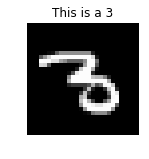

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

<a id='3'></a>

### 3. Train a Model

Now the data is preprocessed and available in the required format. The next step is to train the model by creating the training job using KMeans estimator's fit method.

<a id='3.1'></a>

#### 3.1 Create a Training Job

In [4]:
#This Python library provides the KMeans estimator, which is a class in the sagemaker.amazon.kmeans.KMeans module.
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_highlevel_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

training data will be uploaded to: s3://paragpansarez-sagemaker-1/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://paragpansarez-sagemaker-1/kmeans_highlevel_example/output


Create an instance of the sagemaker.amazon.kmeans.KMeans class

In the constructor, specify the following parameters:

1)  role — The IAM role that Amazon SageMaker can assume to perform tasks on your behalf (for example, reading training results called model artifacts from the S3 bucket and writing training results to S3 bucket).

2) output_path — The S3 location where Amazon SageMaker stores the training results.

3) train_instance_count and train_instance_type — The type and number of ML compute instances to use for model training.

4) k — The number of clusters to create.

5) data_location — The S3 location where the high-level library uploads the transformed training data.

In [5]:
kmeans = KMeans(role=role, train_instance_count=2, train_instance_type='ml.c4.8xlarge', output_path=output_location, k=10, 
                data_location=data_location)

<a id='3.2'></a>

#### 3.2 Start the Training Job

In [8]:
# To start model training, call the KMeans estimator's fit method.
# This is a synchronous operation. The method displays progress logs and waits until training completes before returning.

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-10-06-17-49-22-982


2018-10-06 17:49:23 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training......
2018-10-06 17:51:30 Downloading - Downloading input data
2018-10-06 17:51:50 Training - Downloading the training image.
Docker entrypoint called with argument(s): train
[10/06/2018 17:51:55 INFO 139906244921152] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[10/06/2018 


2018-10-06 17:52:01 Uploading - Uploading generated training model
2018-10-06 17:52:06 Completed - Training job completed
Billable seconds: 72


<a id='3.3'></a>

#### 3.3 Additional Notes - Implicit Actions

We now have trained a model. The resulting model artifacts are stored in the S3 bucket.

1) Docker image:
Typically, we have to specify the registry path of the Docker image that contains the training code. For the registry paths for the algorithms provided by Amazon SageMaker, we don't need to explicitly specify this path when using the high-level Python library. The sagemaker.amazon.kmeans.KMeans object knows the path.

2) Transform training dataset and upload it to S3
For efficient model training, transform the dataset from the numpy.array format to the RecordIO protobuf format. The RecordIO protobuf format is more efficient for all of the algorithms provided by Amazon SageMaker. Fit method for model training performs the necessary transformation implicitly and upload to S3 before starting a model training job.

<a id='4'></a>

### 4. Deploy the Model to Amazon SageMaker

The sagemaker.amazon.kmeans.KMeans class provides the deploy method for deploying a model. It performs all three steps of the model deployment process.

###### 1. Create a model in Amazon SageMaker: 
Requires information such as the location of the S3 bucket that contains model artifacts and the registry path of
the image that contains inference code.

###### 2. Create an endpoint configuration:
Requires resource configuration information for hosting. This includes the type and number of ML compute instances to launch for deploying the model.

###### 3. Create an endpoint:
SageMaker launches the ML compute instances and deploys the model. In the response, Amazon SageMaker returns an endpoint. Applications can send requests to this endpoint to get inferences from the model.

The sagemaker.amazon.kmeans.KMeans instance knows the registry path of the image that contains the k-means inference code, so we don't need to provide it. This is a synchronous operation. The method waits until the deployment completes before returning. It returns a kmeans_predictor.

In [9]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-10-06-17-52-53-415
INFO:sagemaker:Creating endpoint with name kmeans-2018-10-06-17-49-22-982


---------------------------------------------------------------!CPU times: user 260 ms, sys: 36 ms, total: 296 ms
Wall time: 5min 19s


<a id='5'></a>

### 5. Validate the Model

The next step is to validate the model by sending sample requests, which in turn returns inferences.

The kmeans_predictor returned by the deploy call in the preceding step provides the predict method. To get inferences from the model, we need to call this method.

In [10]:
# Get an inference for the 30th image of a handwritten number in the valid_set dataset.
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

# The response shows that the input image belongs to cluster 3. It also shows the mean squared distance for that cluster.
# Note: In the k-means implementation, the cluster numbers and digit they represent don't align. 
# For example, algorithm might group images of the handwritten number 3 in cluster 0, and images of the number 4 in cluster 9.


[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 3.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.440222263336182
    }
  }
}
]





Cluster 0:


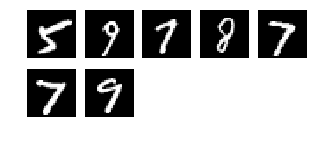




Cluster 1:


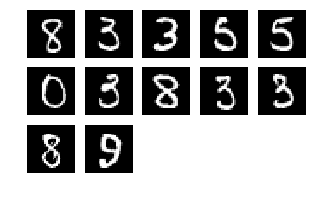




Cluster 2:


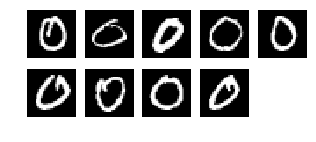




Cluster 3:


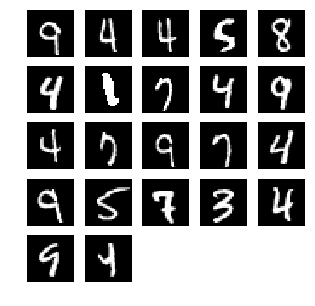




Cluster 4:


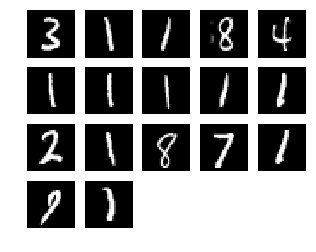




Cluster 5:


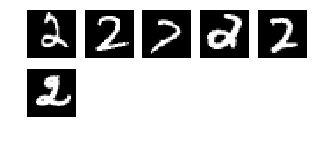




Cluster 6:


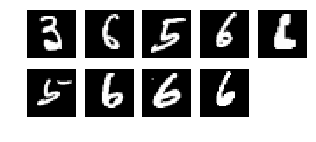




Cluster 7:


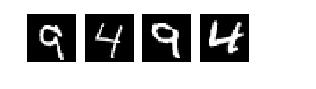




Cluster 8:


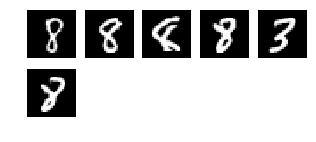




Cluster 9:


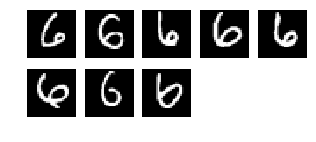

CPU times: user 4.16 s, sys: 1.55 s, total: 5.7 s
Wall time: 3.59 s


In [12]:
%%time
# Get inferences for the first 100 images.

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]


for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5) + 1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')
    
    plt.show()
    
# This code takes the first 100 images of handwritten numbers from the valid_set dataset and generates inferences for them.
# The result is a set of clusters that group similar images.
# The following visualization shows the clusters that the model returned:

So, the conclusion is K-means is not the best algorithm for image analysis problems but it is a good starting point to implement POCs or understand the mechanisms of how SageMaker works.

To improve the model, we might make the following changes to the training job:

• Automatic Model tuning/Hyperparameter tuning - Change the model training parameters. For example, increase the number of epochs or tweak hyperparameters, such extra_center_factor.

• Consider switching the algorithm - The images in the MNIST dataset include information that identifies the digits, called labels. We might then use the label information and a supervised algorithm, such as the linear learner algorithm provided by Amazon SageMaker.

• Try a more specialized algorithm such as the image classification algorithm provided by Amazon SageMaker instead of the linear learner algorithm.

<a id='6'></a>

### 6. Clean Up

In [15]:
# to delete the hosted endpoint and avoid incurring charges

print(kmeans_predictor.endpoint)

import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: kmeans-2018-10-06-17-49-22-982


kmeans-2018-10-06-17-49-22-982
